## Imports

In [9]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score

from skopt import BayesSearchCV

import shap

import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [10]:
data = pd.read_csv("data/Heart_Disease_Kaggle_Preprocessed.csv")
print(data.shape)
data.head()

(268, 14)


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,ECG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,1.733026,0.681528,0.871534,-0.064103,1.407389,-0.418854,0.977857,-1.777056,-0.699206,1.193857,0.680101,2.462874,-0.881493,1
1,1.400801,-1.467290,-0.180588,-0.914581,6.109512,-0.418854,0.977857,0.437459,-0.699206,0.491048,0.680101,-0.715538,1.181740,0
2,0.293383,0.681528,-1.232710,-0.404294,0.222143,-0.418854,-1.022644,-0.387556,-0.699206,-0.651016,-0.947283,-0.715538,1.181740,1
3,1.068576,0.681528,0.871534,-0.177500,0.261004,-0.418854,-1.022644,-1.950743,1.430194,-0.738867,0.680101,0.343933,1.181740,0
4,2.175994,-1.467290,-1.232710,-0.631088,0.377585,-0.418854,0.977857,-1.255994,1.430194,-0.738867,-0.947283,0.343933,-0.881493,0


## Data split

In [11]:
X = data.drop(columns=["Heart Disease"])
y = data["Heart Disease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Metrics settings

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fbeta_scorer = make_scorer(fbeta_score, beta=2)

scoring_metrics = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "fbeta_2": fbeta_scorer,
    "roc_auc": "roc_auc"
}

## Cross-validation

In [13]:
nb = GaussianNB()
scores_nb = cross_validate(nb, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Naive Bayes:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_nb[f"test_{metric}"])
    std_score = np.std(scores_nb[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores Naive Bayes:
Accuracy: 0.8393 ± 0.0837
Precision: 0.8371 ± 0.1061
Recall: 0.7996 ± 0.1029
Fbeta_2: 0.8056 ± 0.0969
Roc_auc: 0.8916 ± 0.0913


## Bayesian Optimization

In [ ]:
search_space = {
    "var_smoothing": (1e-12, 1e-1, "log-uniform")
}

nb_opt = BayesSearchCV(
    estimator=GaussianNB(),
    search_spaces=search_space,
    scoring="roc_auc",  
    cv=cv,
    n_iter=30, 
    n_jobs=-1,
    random_state=42
)

nb_opt.fit(X_train, y_train)

best_params = nb_opt.best_params_

print("Best parameters:", best_params)
print("Best ROC AUC score (cv):", nb_opt.best_score_)

Best parameters: OrderedDict([('var_smoothing', 0.1)])
Best ROC AUC score (cv): 0.8941591704147926


## Cross-validation with best model

In [15]:
nb = GaussianNB(**best_params)
scores_nb = cross_validate(nb, X, y, cv=cv, scoring=scoring_metrics)

print("Scores Naive Bayes:")
for metric in scoring_metrics:
    mean_score = np.mean(scores_nb[f"test_{metric}"])
    std_score = np.std(scores_nb[f"test_{metric}"])
    print(f"{metric.capitalize()}: {mean_score:.4f} ± {std_score:.4f}")

Scores Naive Bayes:
Accuracy: 0.8430 ± 0.0804
Precision: 0.8439 ± 0.1006
Recall: 0.7996 ± 0.1029
Fbeta_2: 0.8068 ± 0.0958
Roc_auc: 0.8942 ± 0.0901


## Feature Importance | SHAP

Using 214 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/54 [00:00<?, ?it/s]

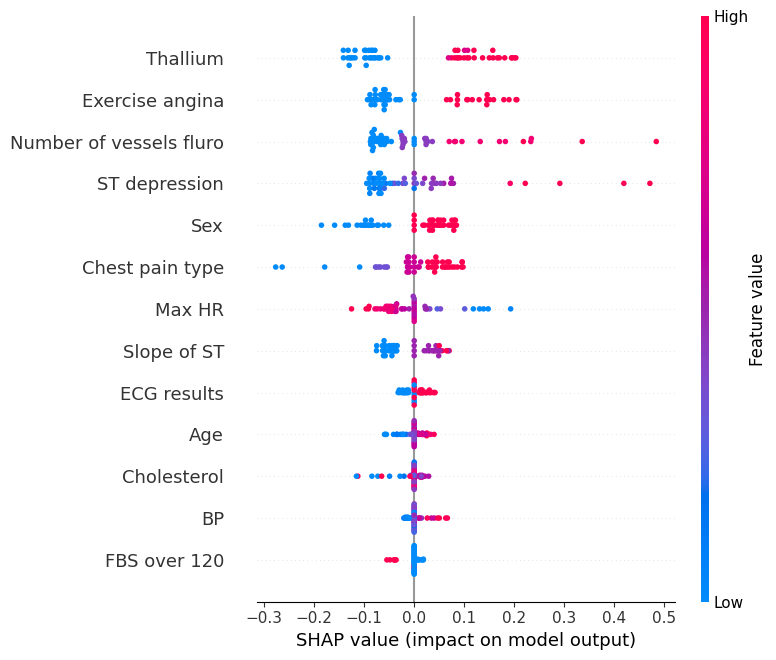

In [16]:
# Train nb model
nb.fit(X_train, y_train)

# Sample for SHAP
X_sample = X_test # X_test[:10]

# Use only the class 1 probability output for SHAP
predict_fn = lambda x: nb.predict_proba(x)[:, 1]

# KernelExplainer
explainer = shap.KernelExplainer(predict_fn, X_train) # X_train[:100]
shap_values = explainer.shap_values(X_sample)

# Plot
shap.summary_plot(shap_values, X_sample, feature_names=X.columns)